# createFolds :

Read all frames from image arrays, augment them, randomize them and save as 10 folds

Requirements: 240 GB RAM, i3.8xlarge aws instance, approx, runtime 1 hour

In [1]:
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import utils; reload(utils)
from utils import *
import gc
import random
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


# Load all frames & Augment the Images

Because the tools tend to be used from bottom to top direction, we crop the images randomly between 15% to 20% from top to bottom direction. And between 5% to 20% from left to right direction

In [2]:
def random_crop(x, random_crop_size):
    w, h = x.shape[1], x.shape[2] 
    rangewby4 = ((w - random_crop_size[0]) // 2) + ((w - random_crop_size[0]) // 4) 
    rangehby4 = (h - random_crop_size[1]) // 4 
    rangew = (w - random_crop_size[0])  
    rangeh = (h - random_crop_size[1])  
    offsetw = 0 if rangew == 0 else np.random.randint(rangewby4,rangew) 
    offseth = 0 if rangeh == 0 else np.random.randint(rangehby4,rangeh) 
    return x[:, offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1]]

In [3]:
def augmentData(mrgb , labels):
       
    flip = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
    totalFrames = mrgb.shape[0]
    
    mrgbAug = np.zeros([totalFrames+15000, 360, 640,3],dtype=np.uint8)
    lAug = np.zeros([totalFrames+15000, 23],dtype=np.int8)
    AugIndex = 0

    #Random cropping, horizontal and vertical flipping    
    #For rare classes boost by 10X
    ##14,5 - 3X
    ##15,16 - 5X
    ##0,9,10,19 - 10X
    ##18,20 - 25X
    for frameIndex in range(totalFrames):
        if sum(np.transpose(labels)[2:22,frameIndex]) == 0: #For 0 labelled frames, discard random 66%
            if not(random.randint(1,3)==1):
                continue
        boost = 1
        if labels[frameIndex,16]==1 or labels[frameIndex,7]==1 or labels[frameIndex,11]==1:
            boost = 3
        if labels[frameIndex,17]==1 or labels[frameIndex,18]==1:
            boost = 5
        if labels[frameIndex,20]==1 or labels[frameIndex,12]==1 or labels[frameIndex,21]==1:
            boost = 10
        if labels[frameIndex,22]==1:
            boost = 25
        if labels[frameIndex,2]==1: 
            boost = 50
        if labels[frameIndex,2]==0.5 or labels[frameIndex,3]==0.5 or labels[frameIndex,4]==0.5 or labels[frameIndex,5]==0.5 or labels[frameIndex,6]==0.5 or labels[frameIndex,7]==0.5 or labels[frameIndex,8]==0.5 or labels[frameIndex,9]==0.5 or labels[frameIndex,10]==0.5 or labels[frameIndex,11]==0.5 or labels[frameIndex,12]==0.5 or labels[frameIndex,13]==0.5 or labels[frameIndex,14]==0.5 or labels[frameIndex,15]==0.5 or labels[frameIndex,16]==0.5 or labels[frameIndex,17]==0.5 or labels[frameIndex,6]==0.5 or labels[frameIndex,18]==0.5 or labels[frameIndex,19]==0.5 or labels[frameIndex,20]==0.5 or labels[frameIndex,21]==0.5 or labels[frameIndex,22]==0.5:
            boost = 0
        if boost>0:
            for boostIndex in range(boost):
                images_0 = np.zeros([1, 360, 640 , 3 ],dtype=np.uint8)
                labels_dummy = np.zeros([1, 1],dtype=np.int8)
                images_0[0] = random_crop(np.expand_dims(mrgb[frameIndex],0),(360,640))[0]
                for x,y in flip.flow(images_0,labels_dummy,batch_size=1):
                    mrgbAug[AugIndex] = x
                    lAug[AugIndex]=labels[frameIndex]
                    AugIndex += 1
                    break
    
    del(mrgb)
    gc.collect()
    return mrgbAug[0:AugIndex],lAug[0:AugIndex]

In [4]:
def createFolds(files):
    FIRST_TIME=True
    rgbNew = np.zeros([150000, 360, 640 , 3 ],dtype=np.uint8)  
    labelsNew = np.zeros([150000,23 ],dtype=np.int8)  
    index = 0
    for i in range(len(files)):
        labels = load_array('/cat/home/ubuntu/cat/in/train/labels/'+files[i]+'_aug_labels.dat')
        rgb = load_array('/cat/home/ubuntu/cat/in/train/hires/'+files[i]+'_hires.dat')[0:labels.shape[0]]
        rgb, labels = augmentData(rgb,labels)
        rgbNew[index:(index+labels.shape[0])] = rgb
        labelsNew[index:(index+labels.shape[0])] = labels
        index += labels.shape[0]
        print files[i],labels.shape,rgb.shape,labelsNew.shape,rgbNew.shape,index 
        del(rgb,labels)
        gc.collect()
    return rgbNew[0:index], labelsNew[0:index]

In [5]:
files = ['train25','train01','train02','train05','train06','train07','train08','train09','train11',
         'train12','train13','train14_minus_val','train15','train16','train17','train19_minus_val','train20',
         'train22','train23','train24_minus_val']
rgb , labels = createFolds(files=files)

train25 (11683, 23) (11683, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 11683
train01 (3577, 23) (3577, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 15260
train02 (3079, 23) (3079, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 18339
train05 (3755, 23) (3755, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 22094
train06 (3586, 23) (3586, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 25680
train07 (4566, 23) (4566, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 30246
train08 (6241, 23) (6241, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 36487
train09 (3636, 23) (3636, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 40123
train11 (3690, 23) (3690, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 43813
train12 (5620, 23) (5620, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 49433
train13 (3433, 23) (3433, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 52866
train14_minus_val (6642, 23) (6642, 360, 640, 3) (150000, 23) (150000, 360, 640, 3) 59508
train15 (3323, 23) (3323, 36

# Randomise the frames

In [6]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [7]:
rgb_new, lbl_new = unison_shuffled_copies(rgb,labels)
del(rgb, labels)
gc.collect()

0

In [14]:
save_array('../in/train/folds/hires_allfolds.dat',rgb_new)
save_array('../in/train/folds/labels_allfolds.dat',lbls_new)

In [7]:
rgb_new = load_array('../in/train/folds/hires_allfolds.dat')
lbls_new = load_array('../in/train/folds/labels_allfolds.dat')

# Create 10 folds

In [8]:
numFolds=5
totalFrames = lbl_new.shape[0]
framesFold = totalFrames/numFolds
for i in range(numFolds):
    save_array('/cat2/home/ubuntu/cat2/in/train/folds/trainfold%d'%i + '_hires.dat',
               rgb_new[i * framesFold : min((i + 1) * framesFold, totalFrames)])
    save_array('/cat2/home/ubuntu/cat2/in/train/folds/trainfold%d'%i + '_labels.dat',
               lbl_new[i * framesFold : min((i + 1) * framesFold, totalFrames)])
    text = 'counts: '
    for j in range(21):
        text = text + ' : ' + str(int(np.sum(lbl_new[i * framesFold : min((i + 1) * framesFold, totalFrames),j+2])))
    print text

counts:  : 201 : 198 : 663 : 929 : 705 : 657 : 1196 : 822 : 623 : 249 : 230 : 3303 : 3954 : 761 : 1079 : 847 : 650 : 4469 : 396 : 246 : 255
counts:  : 182 : 209 : 670 : 843 : 755 : 652 : 1217 : 802 : 627 : 270 : 221 : 3289 : 4019 : 729 : 1162 : 795 : 653 : 4541 : 370 : 278 : 258
counts:  : 209 : 205 : 682 : 859 : 709 : 649 : 1219 : 835 : 618 : 293 : 263 : 3369 : 3898 : 719 : 1131 : 849 : 655 : 4457 : 401 : 300 : 297
counts:  : 237 : 211 : 687 : 882 : 680 : 667 : 1235 : 792 : 633 : 294 : 229 : 3389 : 3977 : 715 : 1112 : 829 : 626 : 4505 : 387 : 267 : 309
counts:  : 221 : 246 : 676 : 856 : 692 : 639 : 1297 : 815 : 664 : 259 : 237 : 3300 : 3984 : 715 : 1071 : 810 : 661 : 4467 : 376 : 249 : 331


In [9]:
framesFold

21380

In [10]:
labels = load_array('/home/ubuntu/cat3/in/train/folds/trainfold9_labels.dat')
rgb = load_array('/home/ubuntu/cat3/in/train/folds/trainfold9_hires.dat')
print labels.shape, rgb.shape

(5305, 23) (5305, 518, 921, 3)


In [11]:
for i in range(21):
    print np.sum(labels[:,i+2])

58
59
181
203
185
153
301
207
169
68
66
845
986
124
279
209
148
1074
87
66
83


In [12]:
labels[508] #13, 18

array([-89,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=int8)

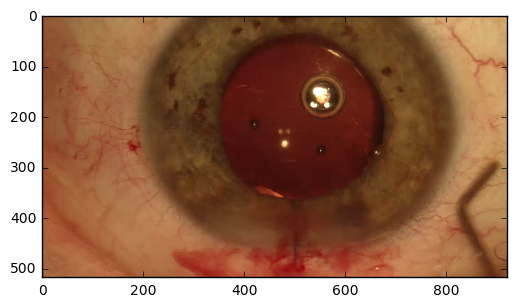

In [13]:
plt.imshow(rgb[508])

In [14]:
labels = load_array('/cat/home/ubuntu/cat/in/train/labels/train10_val_minus_0p5_labels.dat')
rgb = load_array('/cat/home/ubuntu/cat/in/train/hires/train10_val_minus_0p5_hires.dat')
print labels.shape, rgb.shape

(8389, 23) (8389, 518, 921, 3)


In [15]:
labels[500] #13, 18

array([-94, -93,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   0,   0,   0,   0], dtype=int8)

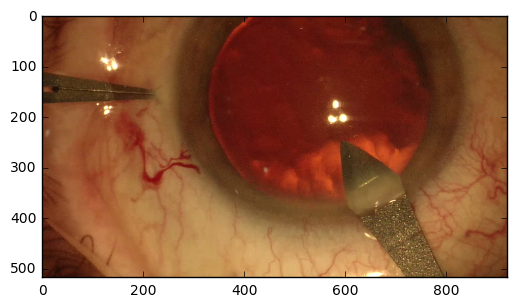

In [16]:
plt.imshow(rgb[501])

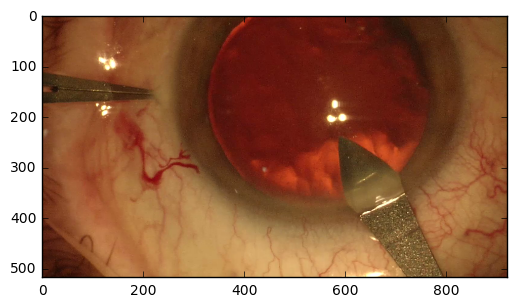

In [17]:
plt.imshow(rgb[502])